In [1]:
import pandas as pd
import glob
import numpy as np
from datetime import timedelta


In [2]:
data_path = "D:/unified_metor_content/fraud_detection/fraud_detection/" 

file_list = sorted(glob.glob(data_path + "*.pkl"))

# Read and concatenate all daily files
df_all = pd.concat([pd.read_pickle(file) for file in file_list], ignore_index=True)

In [3]:
df_all.head()

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO
0,0,2018-04-01 00:00:31,596,3156,57.16,31,0,0,0
1,1,2018-04-01 00:02:10,4961,3412,81.51,130,0,0,0
2,2,2018-04-01 00:07:56,2,1365,146.00,476,0,0,0
3,3,2018-04-01 00:09:29,4128,8737,64.49,569,0,0,0
4,4,2018-04-01 00:10:34,927,9906,50.99,634,0,0,0


In [4]:
pd.set_option('display.max_rows',4000)

In [5]:
df_all[df_all['TX_FRAUD'] == 1]

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO
3527,3527,2018-04-01 10:17:43,3774,3059,225.41,37063,0,1,1
5789,5790,2018-04-01 13:31:48,4944,6050,222.26,48708,0,1,1
6549,6549,2018-04-01 14:42:02,4625,9102,226.40,52922,0,1,1
9583,9583,2018-04-02 01:01:05,3814,6893,59.15,90065,1,1,3
10355,10355,2018-04-02 05:03:35,2513,1143,222.04,104615,1,1,1
...,...,...,...,...,...,...,...,...,...
1753524,1753524,2018-09-30 19:51:48,1671,3192,128.60,15796308,182,1,3
1753600,1753600,2018-09-30 20:09:00,4166,632,17.39,15797340,182,1,2
1753673,1753673,2018-09-30 20:30:52,4097,1558,24.04,15798652,182,1,2
1754014,1754014,2018-09-30 22:27:04,100,8604,73.85,15805624,182,1,3


In [6]:
#df_all['TX_FRAUD_SCENARIO'].unique().values()
df_all['TX_FRAUD_SCENARIO'].value_counts().sort_index()

TX_FRAUD_SCENARIO
0    1739474
1        973
2       9077
3       4631
Name: count, dtype: int64

In [7]:
fraud_terminals = df_all[df_all['TX_FRAUD'] == 1]['TERMINAL_ID'].unique()
print(len(fraud_terminals))

4266


In [8]:
pd.reset_option('display.max_rows')


In [9]:
fraud_terminal_counts = df_all[df_all['TX_FRAUD'] == 1]['TERMINAL_ID'].value_counts()

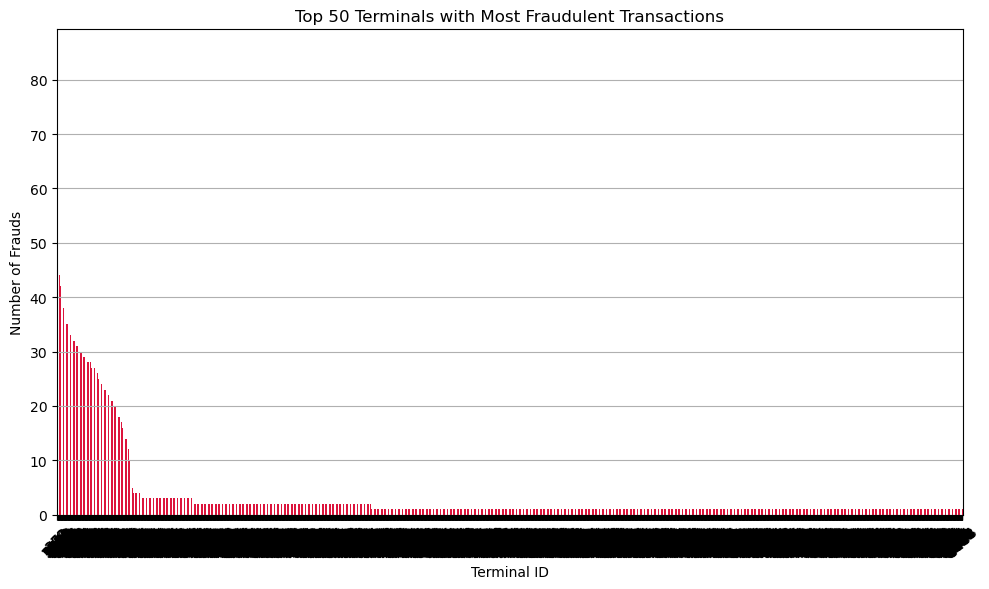

In [10]:
import matplotlib.pyplot as plt
# Select top 10 (or change to 50)
top_n = 50
top_fraud_terminals = fraud_terminal_counts[fraud_terminal_counts > 0]
df_all['fraud_occured'] = fraud_terminal_counts[fraud_terminal_counts > 0]
# Plot
plt.figure(figsize=(10, 6))
top_fraud_terminals.plot(kind='bar', color='crimson')
plt.title(f"Top {top_n} Terminals with Most Fraudulent Transactions")
plt.xlabel("Terminal ID")
plt.ylabel("Number of Frauds")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y')
plt.show()

In [11]:
print(top_fraud_terminals)

TERMINAL_ID
293     85
1244    72
3644    59
7054    50
4692    48
        ..
3411     1
9847     1
9603     1
9895     1
8488     1
Name: count, Length: 4266, dtype: int64


In [14]:
df_all['datetime'] = pd.to_datetime(df_all['TX_DATETIME'])

In [15]:
#if it is in fraud_terminal list and date differnce of last fraud on that terminal and current date is less then 10 days,
#then farud_terminal 1

# Step 1: Sort fraud transactions only
fraud_only = df_all[df_all['fraud_occured'] == 1]

# Step 2: Get the most recent fraud date per terminal
last_fraud_date_per_terminal = (
    fraud_only.groupby('TERMINAL_ID')['datetime']
    .max()
    .rename('last_fraud_date')
)

# Step 3: Map that date back to all transactions in the full DataFrame
df_all['last_fraud_date'] = df_all['TERMINAL_ID'].map(last_fraud_date_per_terminal)



In [17]:
# Make sure both columns are datetime (for safety)
df_all['datetime'] = pd.to_datetime(df_all['datetime'])
df_all['last_fraud_date'] = pd.to_datetime(df_all['last_fraud_date'])

# Calculate time difference (in days)
df_all['days_since_last_fraud'] = (df_all['datetime'] - df_all['last_fraud_date']).dt.days

# Flag recent fraud at terminal (<=10 days and terminal was known fraud terminal)
df_all['fraud_terminal_recent'] = ((df_all['days_since_last_fraud'] <= 10) & 
                                   (df_all['TERMINAL_ID'].isin(
                                       df_all[df_all['fraud_occured'] == 1]['TERMINAL_ID'].unique()
                                   ))).astype(int)


In [19]:
df_all.drop(columns = ['fraud_occured','last_fraud_date','days_since_last_fraud'],inplace = True)

In [20]:
df_all[(df_all['TERMINAL_ID'] == 293) & (df_all['TX_FRAUD'] == 1)] #after '2018-05-12' there are continous frauds on  this terminal

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO,datetime,fraud_terminal_recent
86742,86742,2018-04-10 04:02:24,1081,293,415.05,792144,9,1,3,2018-04-10 04:02:24,0
142905,142905,2018-04-15 19:03:28,4556,293,566.80,1278208,14,1,3,2018-04-15 19:03:28,0
400346,400346,2018-05-12 14:53:54,2405,293,148.11,3596034,41,1,2,2018-05-12 14:53:54,0
402938,402938,2018-05-12 21:45:48,3116,293,160.00,3620748,41,1,2,2018-05-12 21:45:48,0
411024,411024,2018-05-13 16:58:03,4973,293,121.89,3689883,42,1,2,2018-05-13 16:58:03,0
...,...,...,...,...,...,...,...,...,...,...,...
1736162,1736162,2018-09-29 05:40:11,323,293,9.84,15658811,181,1,2,2018-09-29 05:40:11,0
1736996,1736996,2018-09-29 07:36:17,507,293,56.60,15665777,181,1,2,2018-09-29 07:36:17,0
1745643,1745643,2018-09-30 05:45:20,4715,293,49.01,15745520,182,1,2,2018-09-30 05:45:20,0
1750427,1750427,2018-09-30 13:41:15,2405,293,51.60,15774075,182,1,2,2018-09-30 13:41:15,0


In [ ]:
#df_all['datetime'] = pd.to_datetime(df_all['TX_DATETIME'])

In [ ]:
#df_all['TX_HOUR'] = df_all['TX_DATETIME'].dt.hour
#df_all['TX_DAY'] = df_all['TX_DATETIME'].dt.day
#df_all['TX_DAYOFWEEK'] = df_all['TX_DATETIME'].dt.dayofweek  # 0=Monday, 6=Sunday
#df_all['TX_IS_WEEKEND'] = df_all['TX_DAYOFWEEK'].isin([5, 6]).astype(int)
#df_all['TX_IS_NIGHT'] = df_all['TX_HOUR'].between(0, 6).astype(int)

In [ ]:
#fraud_counts= df_all[df_all['TX_FRAUD'] == 1].groupby('TERMINAL_ID').size()
#df_all['fraud_count'] = df_all['TERMINAL_ID'].map(fraud_counts).fillna(0).astype(int)



In [21]:
df_all["fraud_amt"] = (df_all["TX_AMOUNT"] > 220).astype(int)

In [22]:
df_all["fraud_amt"].skew()

23.13908917875502

In [23]:
df_all.head()

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO,datetime,fraud_terminal_recent,fraud_amt
0,0,2018-04-01 00:00:31,596,3156,57.16,31,0,0,0,2018-04-01 00:00:31,1,0
1,1,2018-04-01 00:02:10,4961,3412,81.51,130,0,0,0,2018-04-01 00:02:10,1,0
2,2,2018-04-01 00:07:56,2,1365,146.00,476,0,0,0,2018-04-01 00:07:56,0,0
3,3,2018-04-01 00:09:29,4128,8737,64.49,569,0,0,0,2018-04-01 00:09:29,0,0
4,4,2018-04-01 00:10:34,927,9906,50.99,634,0,0,0,2018-04-01 00:10:34,1,0


In [ ]:
#fraud_counts= df_all[df_all['TX_FRAUD'] == 1].groupby('TERMINAL_ID').size()
#df_all['fraud_count'] = df_all['TERMINAL_ID'].map(fraud_counts).fillna(0).astype(int)


In [ ]:
#df_all['fraud_count'].skew()

In [ ]:
#log_vals_frdcount = np.log10(df_all['fraud_count']+0.001)
#log_vals_frdcount.skew()
#df_all['log_vals_frdcount'] = np.log10(df_all['fraud_count']+0.001)

In [ ]:
#sqrt_frdcount = np.sqrt(df_all['fraud_count'])
#sqrt_frdcount.skew()

In [ ]:
#pip install xgboost

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier

In [ ]:
#print(df_all['TX_AMOUNT'].apply(type).value_counts())


In [25]:
print(df_all.dtypes)

TRANSACTION_ID                    int64
TX_DATETIME              datetime64[ns]
CUSTOMER_ID                      object
TERMINAL_ID                      object
TX_AMOUNT                       float64
TX_TIME_SECONDS                  object
TX_TIME_DAYS                     object
TX_FRAUD                          int64
TX_FRAUD_SCENARIO                 int64
datetime                 datetime64[ns]
fraud_terminal_recent             int32
fraud_amt                         int32
dtype: object


In [ ]:

#np.random.seed(42)

# Parse datetime
#df_all['datetime'] = pd.to_datetime(df_all['TX_DATETIME'])

# Sort by time
#df_all = df_all.sort_values('TX_DATETIME').reset_index(drop=True)

# Create helper columns if not present
#if 'TX_FRAUD' not in df_all.columns:
#    df_all['TX_FRAUD'] = 0
#if 'TX_FRAUD_SCENARIO' not in df_all.columns:
#    df_all['TX_FRAUD_SCENARIO'] = 0

# Add date column
#df_all['date'] = df_all['datetime'].dt.date
#df_all['date'] = df_all['datetime'].dt.floor('D')
# Get all unique transaction dates
#unique_dates = df_all['date'].unique()

# Simulate fraud
#for day in unique_dates[:-14]:
#    current_day = pd.to_datetime(day)
#    window_end = current_day + timedelta(days=14)

#    active_customers = df_all[df_all['date'] == day]['CUSTOMER_ID'].unique()

#    if len(active_customers) < 3:
#        continue

#    selected_customers = np.random.choice(active_customers, size=3, replace=False)

#    for cust_id in selected_customers:
#        mask = (
#            (df_all['CUSTOMER_ID'] == cust_id) &
#            (df_all['datetime'] > current_day) &
#            (df_all['datetime'] <= window_end)
#        )
#        cust_txns = df_all[mask]

#        if len(cust_txns) == 0:
#            continue

#        num_fraud = max(1, len(cust_txns) // 3)
#        fraud_indices = cust_txns.sample(n=num_fraud, random_state=42).index

#        df_all.loc[fraud_indices, 'TX_AMOUNT'] *= 5
#        df_all.loc[fraud_indices, 'TX_FRAUD'] = 1
#        df_all.loc[fraud_indices, 'TX_FRAUD_SCENARIO'] = 4

        #print(f"Injected {num_fraud} frauds for customer {cust_id} on {day}")


In [26]:
df_all['date'] = df_all['datetime'].dt.date

In [27]:
df_all['day'] = df_all['datetime'].dt.day
df_all['month'] = df_all['datetime'].dt.month

In [28]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1754155 entries, 0 to 1754154
Data columns (total 15 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   TRANSACTION_ID         int64         
 1   TX_DATETIME            datetime64[ns]
 2   CUSTOMER_ID            object        
 3   TERMINAL_ID            object        
 4   TX_AMOUNT              float64       
 5   TX_TIME_SECONDS        object        
 6   TX_TIME_DAYS           object        
 7   TX_FRAUD               int64         
 8   TX_FRAUD_SCENARIO      int64         
 9   datetime               datetime64[ns]
 10  fraud_terminal_recent  int32         
 11  fraud_amt              int32         
 12  date                   object        
 13  day                    int32         
 14  month                  int32         
dtypes: datetime64[ns](2), float64(1), int32(4), int64(3), object(5)
memory usage: 174.0+ MB


In [29]:
df_all.drop(columns = ['TRANSACTION_ID','TX_TIME_SECONDS','TX_TIME_DAYS','TX_TIME_DAYS','TX_DATETIME','datetime','date'],inplace = True)

In [30]:
df_all


,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_FRAUD,TX_FRAUD_SCENARIO,fraud_terminal_recent,fraud_amt,day,month
0,596,3156,57.16,0,0,1,0,1,4
1,4961,3412,81.51,0,0,1,0,1,4
2,2,1365,146.00,0,0,0,0,1,4
3,4128,8737,64.49,0,0,0,0,1,4
4,927,9906,50.99,0,0,1,0,1,4
...,...,...,...,...,...,...,...,...,...
1754150,161,655,54.24,0,0,0,0,30,9
1754151,4342,6181,1.23,0,0,0,0,30,9
1754152,618,1502,6.62,0,0,0,0,30,9
1754153,4056,3067,55.40,0,0,0,0,30,9


In [ ]:
#df_all['avg_tx_amt_14d'] = df_all.groupby('CUSTOMER_ID')['TX_AMOUNT'].transform(
#    lambda x: x.rolling(window=14, min_periods=1).mean().fillna(method='ffill')
#          .fillna(0)
#)


In [ ]:
#df_all['avg_tx_amt_14d'].skew()

In [ ]:
#df_all['std_tx_amt_14d'] = df_all.groupby('CUSTOMER_ID')['TX_AMOUNT'].transform(
#    lambda x: x.rolling(window=14, min_periods=1).std().fillna(method='ffill')
#          .fillna(0)
#)


In [ ]:
#df_all['std_tx_amt_14d'].skew()

In [ ]:
#log_vals = np.log1p(X['std_tx_amt_14d'])
#df_all['log_vals_std'] = np.log1p(X['std_tx_amt_14d'])
#log_vals.skew()

In [ ]:
#df_all['unique_terminals_28d'] = (
#   df_all.sort_values(['CUSTOMER_ID', 'datetime'])
#         .groupby('CUSTOMER_ID')
#         .rolling('28D', on='datetime')['TERMINAL_ID']
#         .apply(lambda x: x.nunique(), raw=False)
#         .reset_index(level=0, drop=True)
#         .reset_index(drop=True)
#)


#df_all['unique_terminals_28d'] = df_all['unique_terminals_28d'].fillna(0)


In [ ]:
#df_all['unique_terminals_28d'].skew()

In [ ]:
#not useful feature:
#df_all = df_all.sort_values(['CUSTOMER_ID', 'datetime'])

#df_all['tx_count_14d'] = (
    #df_all.groupby('CUSTOMER_ID')
          #.rolling('14D', on='datetime')['TX_AMOUNT']
          #.count()
          #.reset_index(level=0, drop=True)
    #.reset_index(drop=True)
#)

#df_all['tx_count_14d'] = df_all['tx_count_14d'].fillna(0)



In [ ]:
 #df_all['is_new_terminal'] = (
    #df_all.groupby('CUSTOMER_ID')['TERMINAL_ID']
    #     .transform(lambda x: ~x.duplicated())
#).astype(int)


In [ ]:
#df_all['is_new_terminal'].skew()

In [ ]:
#log_vals_isnew = np.log1p(df_all['is_new_terminal'])
#log_vals_isnew.skew()

In [ ]:
#sqrt_isnew = np.sqrt(df_all['is_new_terminal'])
#sqrt_isnew.skew()

In [ ]:
#df_all['amount_mean'] = df_all.groupby('CUSTOMER_ID')['TX_AMOUNT'].transform('mean')
#df_all['amount_std'] = df_all.groupby('CUSTOMER_ID')['TX_AMOUNT'].transform('std')
#df_all['amount_zscore'] = (
#   (df_all['TX_AMOUNT'] - df_all['amount_mean']) / df_all['amount_std']
#).fillna(0)


In [ ]:
#df_all['amount_zscore'].skew()

In [ ]:
#log_vals_zscore = np.log10(df_all['amount_zscore']+0.001)
#log_vals_zscore.skew()

In [ ]:
#sqrt_zscore = np.sqrt(df_all['amount_zscore'])
#df_all['sqrt_zscore'] = np.sqrt(df_all['amount_zscore'])
#sqrt_zscore.skew()

In [ ]:
#df_all['amount_ratio'] = (
#    df_all['TX_AMOUNT'] / df_all['amount_mean']
#).fillna(1)


In [ ]:
#df_all['amount_ratio'].skew()

In [ ]:
#sqrt_ratio = np.sqrt(df_all['amount_ratio'])
#df_all['sqrt_ratio'] = np.sqrt(df_all['amount_ratio'])

#sqrt_ratio.skew()

In [ ]:
#df_all['is_weekend'] = df_all['datetime'].dt.weekday >= 5  # Saturday=5, Sunday=6
#df_all['is_weekend'] = df_all['is_weekend'].astype(int)


In [ ]:
#df_all['is_weekend'].skew()

In [ ]:
#df_all.drop(columns=['amount_mean', 'amount_std'], inplace=True)  # used only for intermediate steps


In [ ]:
#df_all['unique_terminals_7d'] = df_all.groupby('CUSTOMER_ID')['TERMINAL_ID'].transform(
   #lambda x: x.rolling(window=7, min_periods=1).apply(lambda y: len(set(y)))
#)


In [ ]:
#df_all[df_all['TX_FRAUD'] == 1].head()

In [ ]:
#feature_columns = ['TX_AMOUNT','TX_TIME_SECONDS','TX_TIME_DAYS','avg_tx_amt_14d','std_tx_amt_14d','tx_count_14d','amount_zscore','amount_ratio']
#X = df_all[feature_columns]  # Replace with your actual feature list
#y = df_all['TX_FRAUD']


In [ ]:
#from sklearn.preprocessing import StandardScaler

#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X)
#X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)


In [ ]:
#import seaborn as sns
#import matplotlib.pyplot as plt

# Compute correlation
#corr_matrix = X_scaled_df.corr()

# Plot heatmap
#plt.figure(figsize=(12, 10))
#sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
#plt.title("Correlation Heatmap of Scaled Features")
#plt.tight_layout()
#plt.show()


In [ ]:


#for col in X.columns:
    #plt.figure(figsize=(6, 4))
    #sns.boxplot(data=df_all, x='TX_FRAUD', y=col)
    #plt.title(f'{col} vs Fraud')
    #plt.xlabel('Fraud (1=Yes, 0=No)')
    #plt.ylabel(col)
    #plt.tight_layout()
    #plt.show()


In [ ]:
#sns.countplot(data=df_all, x='is_weekend', hue='TX_FRAUD')
#plt.title("is_weekend vs Fraud")
#plt.show()


In [ ]:
#sns.countplot(data=df_all, x='is_new_terminal', hue='TX_FRAUD')
#plt.title("is_new_terminal vs Fraud")
#plt.show()

In [40]:
from sklearn.utils import resample

df_majority = df_all[df_all.TX_FRAUD == 0]
df_minority = df_all[df_all.TX_FRAUD == 1]

df_majority_downsampled = resample(df_majority,
                                   replace=False,
                                   n_samples=len(df_minority)*5,
                                   random_state=42)

df_all = pd.concat([df_majority_downsampled, df_minority])


In [41]:
# Sort by time


#df['TX_TIME_SECONDS'] = pd.to_numeric(df['TX_TIME_SECONDS'], errors='coerce')
#df['TX_TIME_DAYS'] = pd.to_numeric(df['TX_TIME_DAYS'], errors='coerce')
df_all['CUSTOMER_ID'] = pd.to_numeric(df_all['CUSTOMER_ID'], errors='coerce')
df_all['TERMINAL_ID'] = pd.to_numeric(df_all['TERMINAL_ID'], errors='coerce')
# Define your split point (e.g., 70% of the data for training)


X = df_all.drop(columns = ['TX_FRAUD','TX_FRAUD_SCENARIO'])
y = df_all['TX_FRAUD']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [ ]:
#numeric_features = ['TX_AMOUNT', 'std_tx_amt_14d','amount_zscore']
#preprocessor = ColumnTransformer(transformers = [('num',StandardScaler(),numeric_features)],
                                #remainder = 'passthrough',
                                #force_int_remainder_cols=False)


In [42]:
from sklearn.ensemble import RandomForestClassifier

steps=[
    #('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
]
pipeline1 = Pipeline(steps)

#pipeline1 = Pipeline([('xg',XGBClassifier(scale_pos_weight=110,  # Use ratio of non-fraud/fraud
    
   # eval_metric='logloss'))])

In [43]:
pipeline1.fit(X_train, y_train)

Pipeline(steps=[('classifier', RandomForestClassifier())])

In [44]:
import numpy as np
print("Training class distribution:", np.unique(y_train, return_counts=True))


Training class distribution: (array([0, 1], dtype=int64), array([58723, 11745], dtype=int64))


In [ ]:
#pipeline1.fit(X_train, y_train)

In [45]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_auc_score
)

def log_to_text(model_name, y_test, y_pred, y_proba, filename='new_results_log.txt'):
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, y_proba)
    cm = confusion_matrix(y_test, y_pred)
    
    with open(filename, 'a') as f:
        f.write(f"\nModel: {model_name}\n")
        f.write(f"Accuracy: {acc}\n")
        f.write(f"Precision: {prec}\n")
        f.write(f"Recall: {rec}\n")
        f.write(f"F1 Score: {f1}\n")
        f.write(f"ROC AUC: {auc}\n")
        f.write(f"Confusion Matrix:\n{cm}\n")
        f.write("-" * 40 + "\n")


In [46]:
y_pred = pipeline1.predict(X_test)
y_proba = pipeline1.predict_proba(X_test)[:, 1] 
log_to_text('randam forest simple after undersampling',y_test,y_pred,y_proba)

In [47]:
df_comparision = pd.DataFrame({
    'y_test' : y_test.values,
    'y_pred' : y_pred
})

In [48]:
df_comparision

,y_test,y_pred
0,0,0
1,0,0
2,1,0
3,0,0
4,0,0
...,...,...
17613,0,0
17614,0,0
17615,0,0
17616,0,0


In [49]:

# Basic metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Classification report (prints everything)
report = classification_report(y_test, y_pred)

# If you want AUC, use predicted probabilities
y_proba = pipeline1.predict_proba(X_test)[:, 1]  # Prob of class 1
auc = roc_auc_score(y_test, y_proba)

# Print everything
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC:", auc)
print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", report)


Accuracy: 0.8733681462140992
Precision: 0.9272727272727272
Recall: 0.260558583106267
F1 Score: 0.40680670034565275
ROC AUC: 0.8305722437379994

Confusion Matrix:
 [[14622    60]
 [ 2171   765]]

Classification Report:
               precision    recall  f1-score   support

           0       0.87      1.00      0.93     14682
           1       0.93      0.26      0.41      2936

    accuracy                           0.87     17618
   macro avg       0.90      0.63      0.67     17618
weighted avg       0.88      0.87      0.84     17618



In [ ]:
#print(X.dtypes)